In [96]:
import os
from pathlib import Path
import pydicom
from pandas import DataFrame

import matplotlib.pyplot as plt
import numpy as np

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.utils   import *
from LazyLuna.Tables  import *
from LazyLuna.Figures import *
from LazyLuna.loading_functions import *

In [2]:
# annotations from cvi42 workspace
# automatically finds both image folders
# get sops from it
# load images (seriesdescription) from first case with annotations
# load images from second case with the same image positions
# sort into category so that the same annotation is provided for both

In [3]:
bp        = '/Users/dietrichhadler/Desktop/Daten/FatFraction'
bp_annos  = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Gold'
bp_imgs1  = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Original'
bp_imgs2  = '/Users/dietrichhadler/Desktop/Daten/FatFraction/FF_Map'
bp_cases  = '/Users/dietrichhadler/Desktop/Daten/FatFraction/Cases'

In [4]:
parse_cvi42ws(bp_annos, bp_annos, process=True, debug=False)

Found a total of 2073 UIDs in MyoMet-CMR-003190001011438181.2.826.0.1.3680043.8.498.73264295960989188503828783270250065778
   Collected 56 Contours/Points for 13 different Series Subinstance UIDs
   Done parsing Workspace - took 0.07840585708618164 Seconds.

Found a total of 2101 UIDs in MyoMet-CMR-013190001011405161.2.826.0.1.3680043.8.498.11100749889683209149725328693249788299
   Collected 54 Contours/Points for 12 different Series Subinstance UIDs
   Done parsing Workspace - took 0.0741720199584961 Seconds.

Found a total of 2118 UIDs in MyoMet-CMR-002190001011428551.2.826.0.1.3680043.8.498.58409293382900906775012811445329435175
   Collected 56 Contours/Points for 13 different Series Subinstance UIDs
   Done parsing Workspace - took 0.13703703880310059 Seconds.

Found a total of 2190 UIDs in MyoMet-CMR-014190001011217431.2.826.0.1.3680043.8.498.10870335773251806042383439141487174430
   Collected 63 Contours/Points for 14 different Series Subinstance UIDs
   Done parsing Workspace - 

In [117]:
n     = 0
paths = get_imgs_and_annotation_paths(bp_imgs1, bp_annos)
imgp, annop = paths[n]
#BELOW: DOES NOT WORK
#paths = get_imgs_and_annotation_paths(bp_imgs2, bp_annos)
#imgp2, _ = paths[n]
if n==0: imgp2 = os.path.join(bp_imgs2, 'MyoMet-CMR-015_')
if n==2: imgp2 = os.path.join(bp_imgs2, 'MyoMet-CMR-002_')
if n==5: imgp2 = os.path.join(bp_imgs2, 'MyoMet-CMR-013_065Y')
print(imgp)
print(imgp2)

/Users/dietrichhadler/Desktop/Daten/FatFraction/Original/MyoMet-CMR-015Re_060Y
/Users/dietrichhadler/Desktop/Daten/FatFraction/FF_Map/MyoMet-CMR-015_


In [118]:
annos = [Annotation(os.path.join(annop,a), a.replace('.pickle','')) for a in os.listdir(annop) if 'case' not in a]
annos = {a.sop:a for a in annos}
sops  = [a.sop for a in annos.values()]
dcms  = []
for ip, p in enumerate(Path(imgp).glob('**/*.dcm')):
    try:
        p = str(p)
        dcm = pydicom.dcmread(p, stop_before_pixels=True)
        if dcm.SOPInstanceUID in sops:
            dcm = pydicom.dcmread(p, stop_before_pixels=False)
            dcms.append(dcm)
    except:
        pass
dcms = {dcm.SOPInstanceUID:dcm for dcm in dcms}
instance_nr = int(list(dcms.values())[0].InstanceNumber)
print(len(annos))
print(len(dcms))
print(instance_nr)

12
12
22


In [119]:
sd = 'stanre_rs3dt2d_1111_iiNav_IRprep_Dixon-TRA_Acc3.5_GMDMocoCGSense_W_tf2d14 _retro_iPAT_ sax + RV 7 0_FF'
dcms2 = []
for ip, p in enumerate(Path(imgp2).glob('**/*.dcm')):
    try:
        p = str(p)
        dcm = pydicom.dcmread(p, stop_before_pixels=True)
        if dcm.SeriesDescription == sd:
            dcm = pydicom.dcmread(p, stop_before_pixels=False)
            dcms2.append(dcm)
    except:
        pass
dcms2 = sorted(dcms2, key=lambda x: float(x.SliceLocation))
dcms_tmp = dict()
for sop in dcms.keys():
    dcm = dcms[sop]
    slloc = dcm.SliceLocation
    for dcm2 in dcms2:
        if dcm2.SliceLocation==slloc:
            dcms_tmp[sop] = dcm2
dcms2 = dcms_tmp
print(len(dcms2))

12


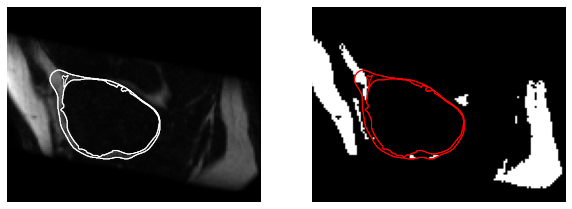

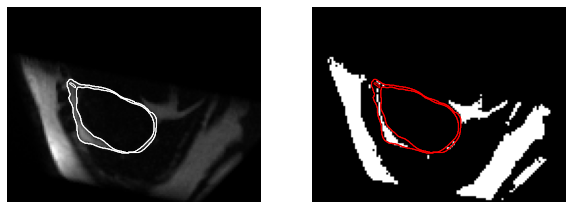

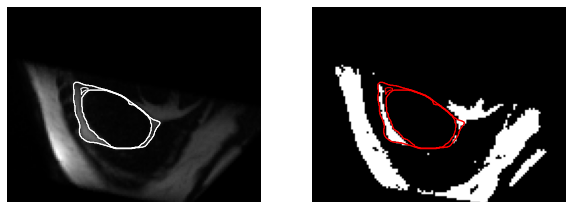

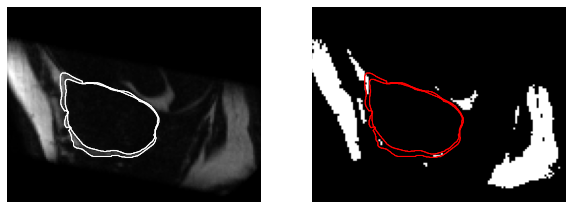

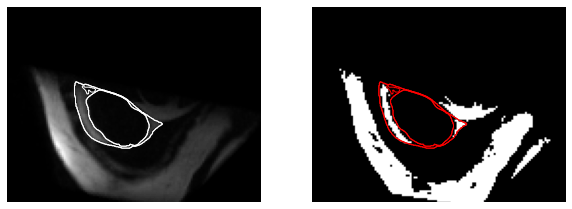

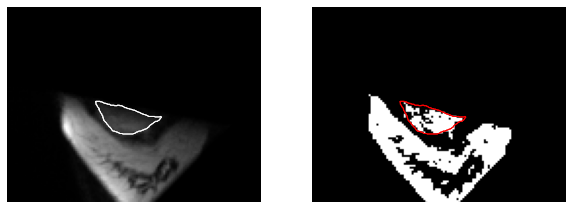

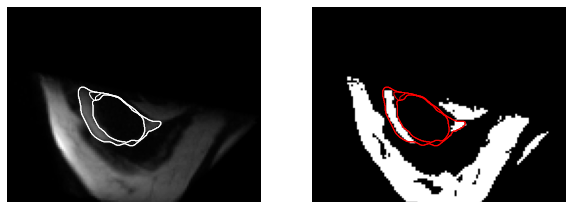

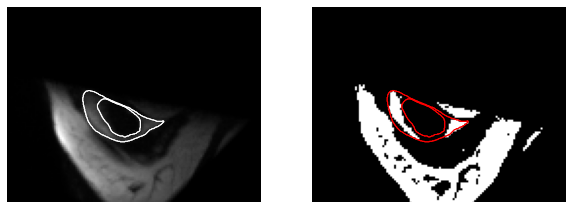

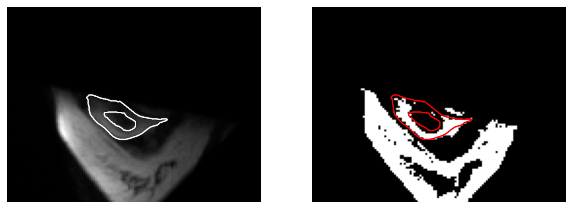

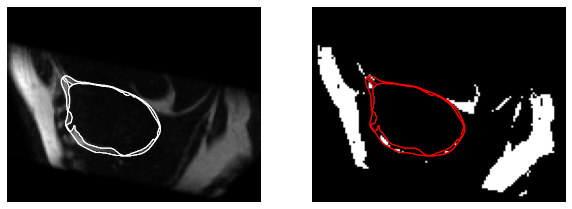

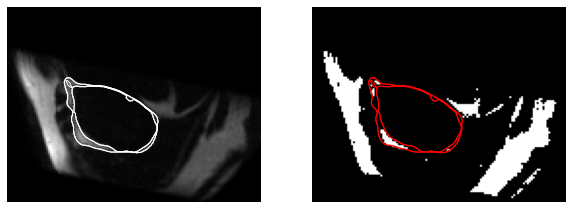

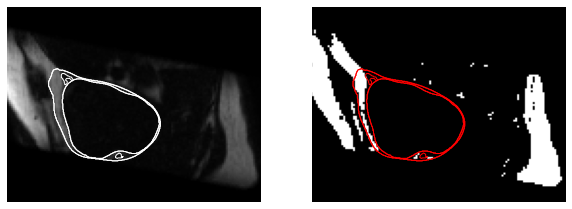

In [120]:
for sop in dcms2.keys():
    img1 = dcms[sop].pixel_array
    img2 = dcms2[sop].pixel_array
    h, w = img1.shape
    anno = annos[sop]
    fig, axes = plt.subplots(1,2, figsize=(10,15))
    extent=(0, w, h, 0)
    axes[0].imshow(img1, cmap='gray', extent=extent); axes[0].axis('off')
    axes[1].imshow(img2, cmap='gray', extent=extent); axes[1].axis('off')
    anno.plot_all_contour_outlines(axes[0])
    anno.plot_all_contour_outlines(axes[1], 'r')
    for ax in axes: ax.set_xlim([20, 150]); ax.set_ylim([50, 150]); 
    plt.show()


In [121]:
class FF_Category:
    def __init__(self, dcms_fat, dcms_ff, annos):
        self.dcms_fat  = dcms_fat 
        self.dcms_ff   = dcms_ff
        self.annos     = annos
        self.depth2sop = self.sort_sops_2_depth(dcms_fat)
        self.nr_slices = len(self.depth2sop.values())
        self.set_params()
        
    def set_params(self):
        dcm1, dcm2 = self.get_fat_dcm(0), self.get_fat_dcm(1)
        self.slice_thickness = dcm1.SliceThickness
        self.spacing_between_slices = np.abs(dcm1.SliceLocation - dcm2.SliceLocation)
        self.ph, self.pw = dcm1.PixelSpacing
        
    def sort_sops_2_depth(self, dcms):
        sl_locs = [(dcm.SOPInstanceUID, float(dcm.SliceLocation)) for dcm in dcms.values()]
        sl_locs = sorted(sl_locs, key=lambda x:x[1])
        depth2sop = {i:x[0] for i,x in enumerate(sl_locs)}
        return depth2sop
        
    def get_fat_dcm(self, depth): return self.dcms_fat[self.depth2sop[depth]]
    def get_ff_dcm (self, depth): return self.dcms_ff[self.depth2sop[depth]]
    def get_fat_img(self, depth): return self.get_fat_dcm(depth).pixel_array
    def get_ff_img (self, depth): return self.get_ff_dcm(depth).pixel_array
    def get_anno   (self, depth): return self.annos[self.depth2sop[depth]]
    
    def get_ff_in_myo(self, depth):
        ff_cont = utils.to_polygon(self.get_ff_img(depth))
        anno = self.get_anno(depth)
        pixels_inside_myo = anno.get_contour('lv_myo').intersection(ff_cont)
        pixels_inside_myo = utils.geometry_collection_to_Polygon(pixels_inside_myo)
        return pixels_inside_myo
    
    # in ml
    def get_ff_volume(self):
        dcm_tmp = self.get_ff_dcm(0)
        ph, pw = self.ph, self.pw
        annos = [self.get_ff_in_myo(d) for d in range(self.nr_slices)]
        areas = [self.get_ff_in_myo(d).area for d in range(self.nr_slices)]
        has_conts = [a!=0 for a in areas]
        top_idx, bot_idx  = has_conts.index(True), self.nr_slices-has_conts[::-1].index(True)-1
        total_vol = 0
        for d in range(self.nr_slices):
            area = self.get_ff_in_myo(d).area - anno.get_contour('rv_pamu').area
            pd   = (self.slice_thickness+self.spacing_between_slices)/2 if d in [top_idx, bot_idx] else self.spacing_between_slices
            total_vol += ph * pw * pd * area
        return total_vol / 1000
    
    # in ml
    def get_fat_volume(self):
        dcm_tmp = self.get_fat_dcm(0)
        ph, pw = self.ph, self.pw
        annos = [self.get_anno(d) for d in range(self.nr_slices)]
        areas = [a.get_contour('lv_myo').area if a is not None else 0.0 for a in annos]
        has_conts = [a!=0 for a in areas]
        top_idx, bot_idx  = has_conts.index(True), self.nr_slices-has_conts[::-1].index(True)-1
        total_vol = 0
        for d in range(self.nr_slices):
            anno = self.get_anno(d)
            area = anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area
            pd   = (self.slice_thickness+self.spacing_between_slices)/2 if d in [top_idx, bot_idx] else self.spacing_between_slices
            total_vol += ph * pw * pd * area
        return total_vol / 1000
    
    def get_area_table(self):
        rows = []
        ph, pw = self.ph, self.pw
        pd = self.spacing_between_slices
        for d in range(self.nr_slices):
            anno = self.get_anno(d)
            area1 = ph*pw*(anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area)
            area2 = ph*pw*self.get_ff_in_myo(d).area
            vol1  = pd * area1
            rows.append([area1, pd*area1/1000, area2, pd*area2/1000])
        cols = ['Fat Areas [mm^2]', 'Fat Volume [ml]', 'FF Areas [mm^2]', 'FF Volume [ml]']
        return DataFrame(rows, columns=cols)
    
    def get_cr_table(self):
        rows = [[cat.get_fat_volume(), cat.get_ff_volume()]]
        cols = ['Fat Volume [ml]', 'FF Volume [ml]']
        return DataFrame(rows, columns=cols)
    
    def store_tables(self, folder_path, case_name):
        df = self.get_cr_table()
        path = os.path.join(folder_path, case_name+'_clinical_result.csv')
        pandas.DataFrame.to_csv(df, path, sep=';', decimal=',')
        df = self.get_area_table()
        path = os.path.join(folder_path, case_name+'_areas.csv')
        pandas.DataFrame.to_csv(df, path, sep=';', decimal=',')

cat = FF_Category(dcms, dcms2, annos)

display(cat.get_area_table())
display(cat.get_cr_table())
cat.store_tables(folder_path=bp_cases)

,Fat Areas [mm^2],Fat Volume [ml],FF Areas [mm^2],FF Volume [ml]
0,1290.439808,9.033080,461.605816,3.231241
1,1143.058900,8.001413,221.316180,1.549213
2,857.722608,6.004059,82.136702,0.574957
3,773.137719,5.411965,100.008473,0.700059
4,815.981006,5.711868,198.303215,1.388123
5,943.898820,6.607293,279.215823,1.954511
6,922.109948,6.454770,399.054617,2.793383
7,1069.613265,7.487294,446.182233,3.123276
8,1028.238891,7.197673,517.179680,3.620258
9,1196.674214,8.376721,571.407041,3.999850


,Fat Volume [ml],FF Volume [ml]
0,88.348866,26.772773


In [122]:
path = os.path.join(bp_cases, 'test_cat.pickle')
pickle.dump(cat, open(path, 'wb'), pickle.HIGHEST_PROTOCOL)

In [123]:
new_cat = pickle.load(open(path, 'rb'))
cat = new_cat

0
329.4375
117.84375


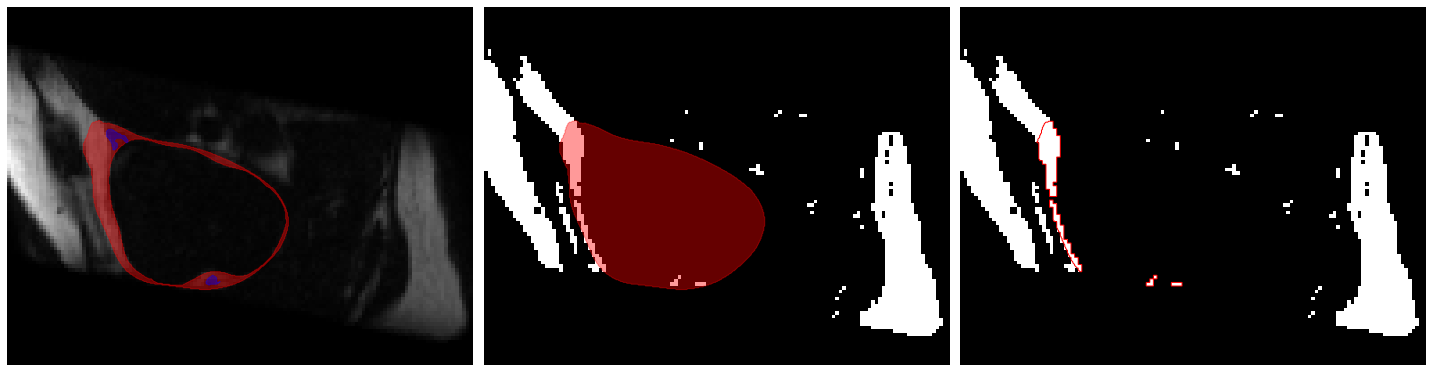

1
291.8125
56.5


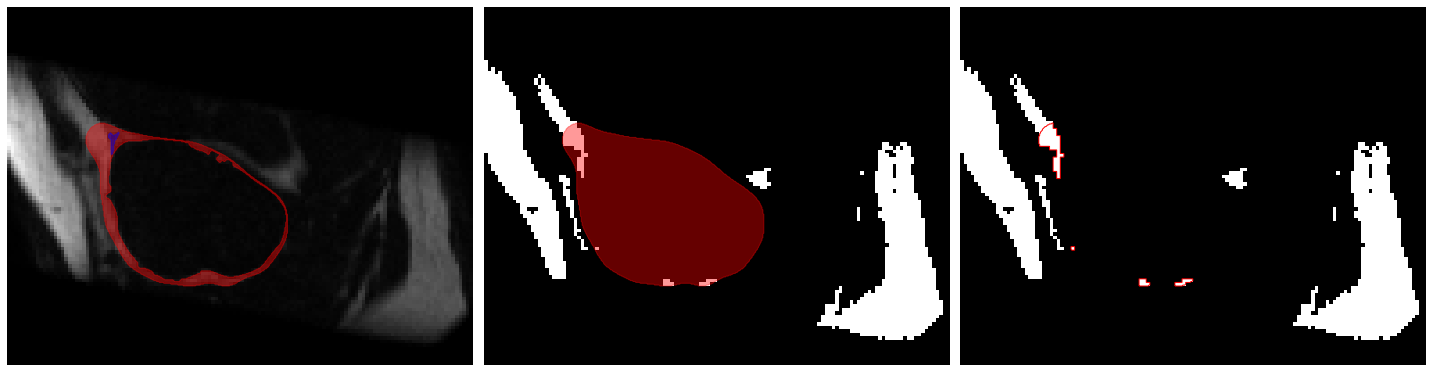

2
218.96875
20.96875


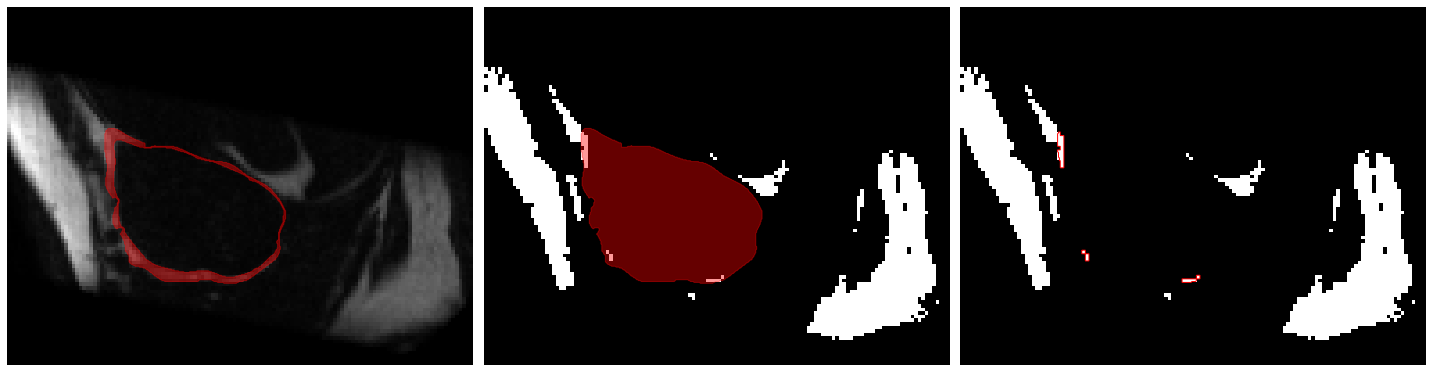

3
197.375
25.53125


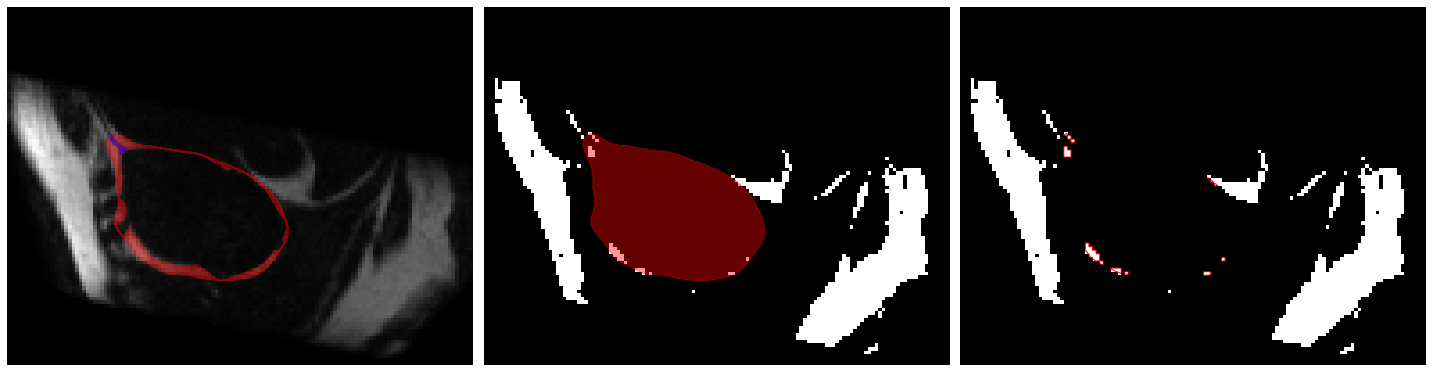

4
208.3125
50.625


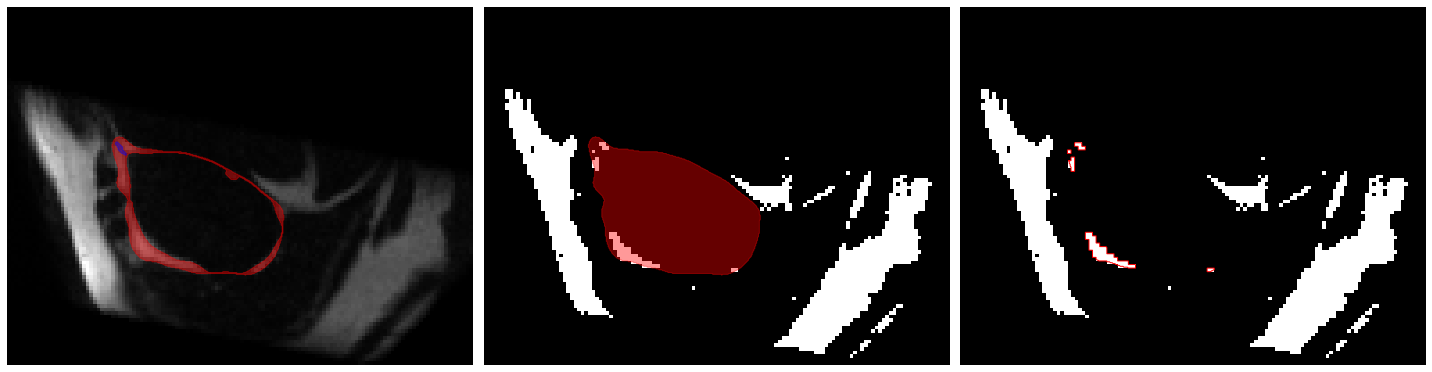

5
240.96875
71.28125


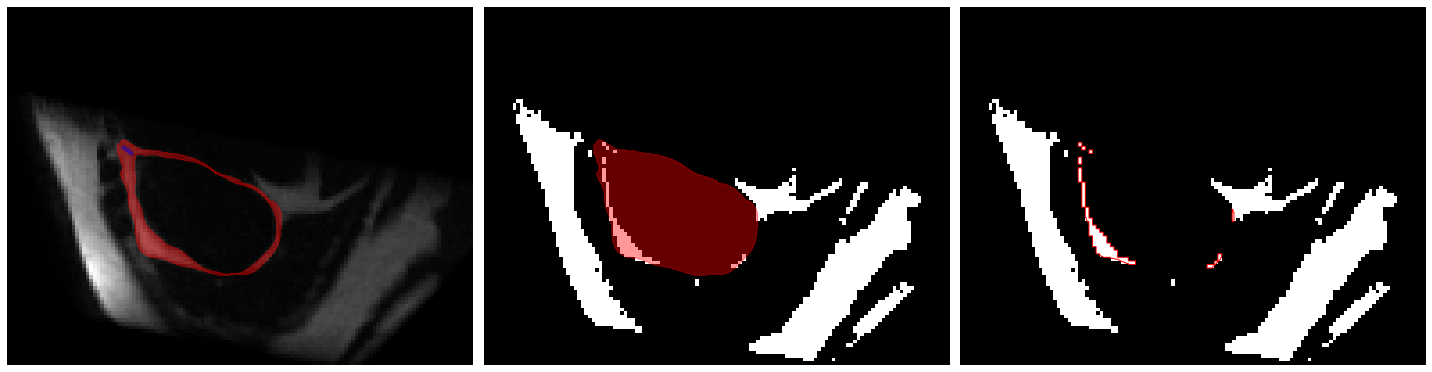

6
235.40625
101.875


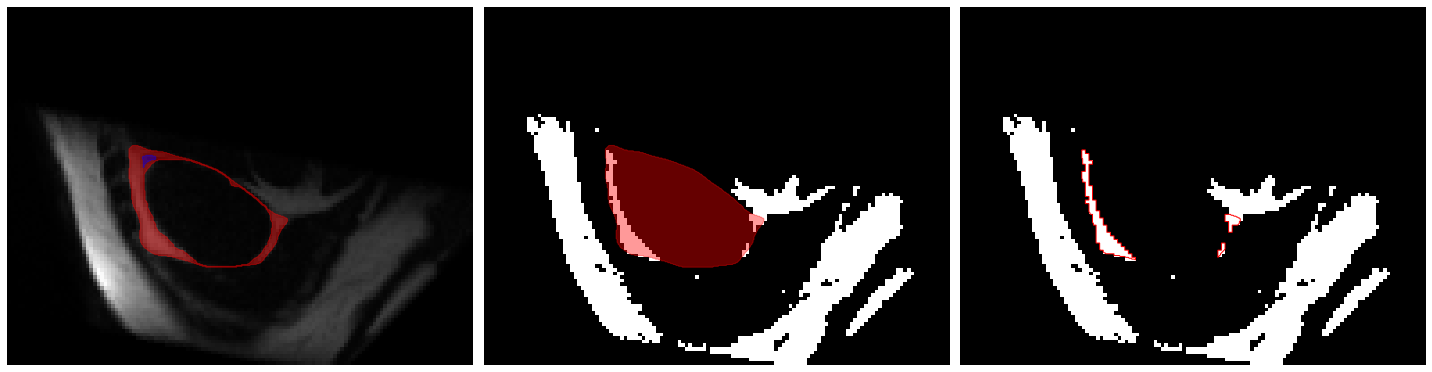

7
273.0625
113.90625


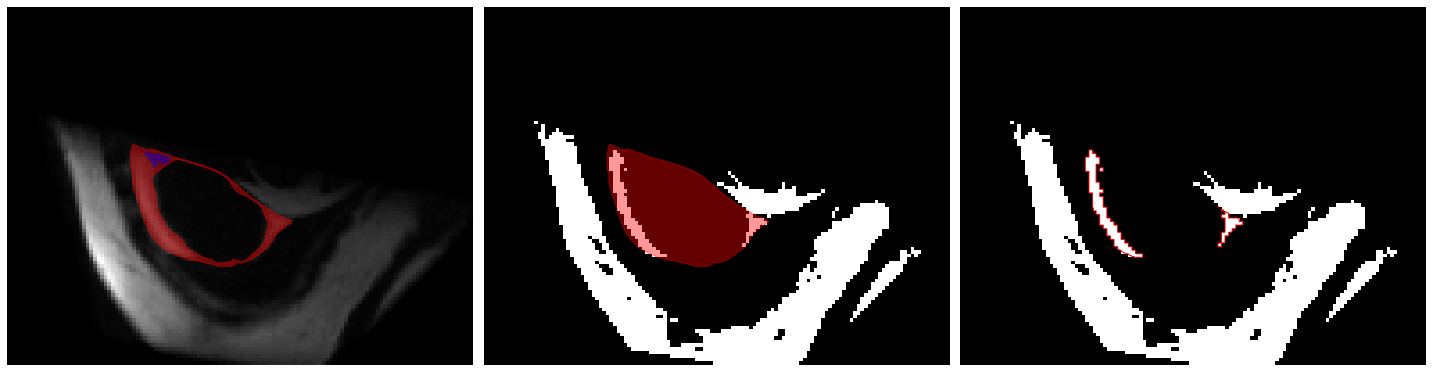

8
262.5
132.03125


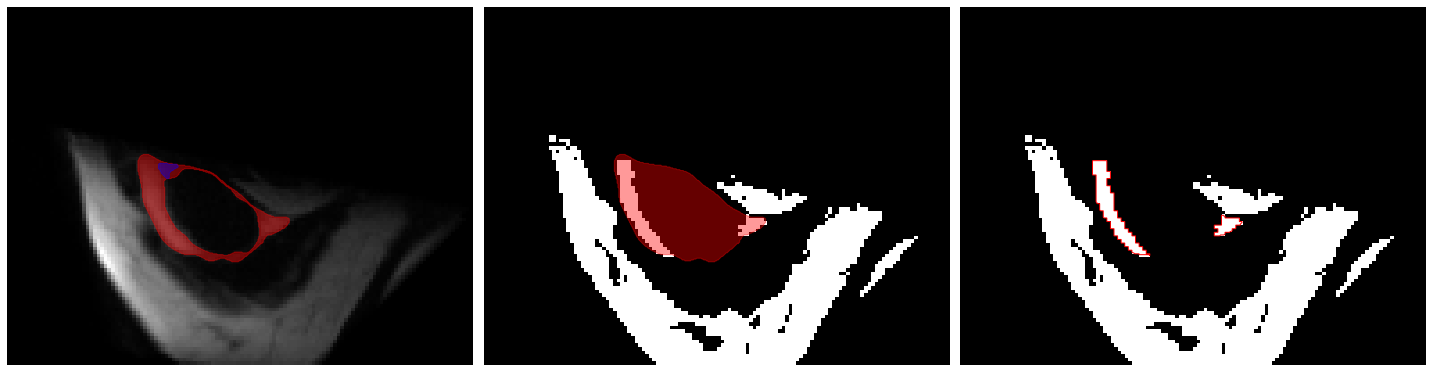

9
305.5
145.875


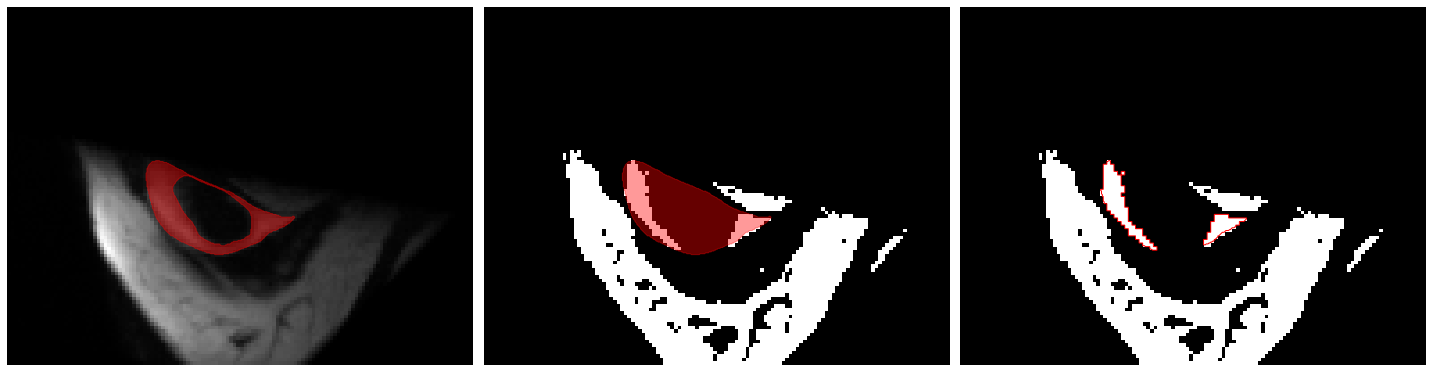

10
358.875
191.90625


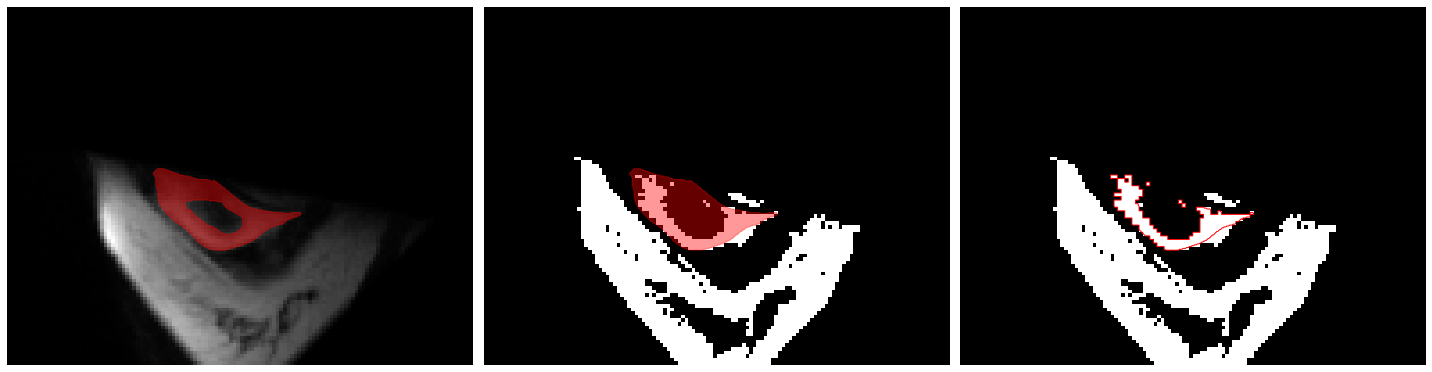

11
299.875
194.8125


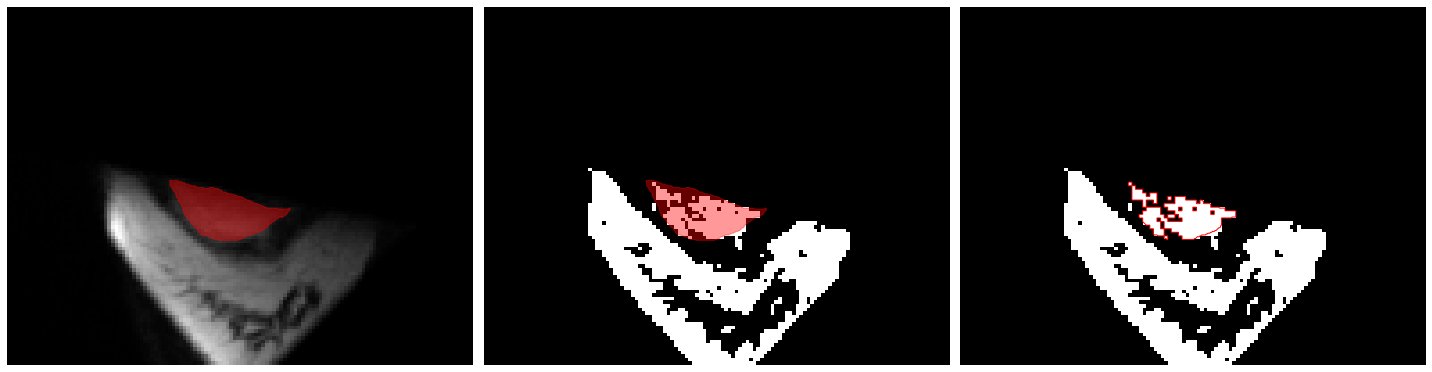

In [126]:
for d in range(cat.nr_slices):
    fig, axes = plt.subplots(1,3, figsize=(20,9))
    img    = cat.get_fat_img(d)
    h, w   = img.shape
    ph, pw = cat.ph, cat.pw
    extent = (0, w, h, 0)
    axes[0].imshow(cat.get_fat_img(d), cmap='gray', extent=extent); axes[0].axis('off')
    axes[1].imshow(cat.get_ff_img(d) , cmap='gray', extent=extent); axes[1].axis('off')
    axes[2].imshow(cat.get_ff_img(d) , cmap='gray', extent=extent); axes[2].axis('off')
    anno = cat.get_anno(d)
    anno.plot_contour_face(axes[0], 'lv_myo')
    anno.plot_contour_face(axes[0], 'rv_pamu', 'b')
    #anno.plot_contour_face(axes[1], 'lv_myo')
    anno.plot_contour_face(axes[1], 'lv_epi')
    #anno.plot_contour_face(axes[1], 'rv_pamu', 'b')
    ff_pixel_polygon = cat.get_ff_in_myo(d)
    utils.plot_outlines(axes[2], ff_pixel_polygon, 'r')
    for ax in axes:
        ax.set_xlim([20, 150]); ax.set_ylim([50, 150]); 
    print(d)
    #pixel_area = ph*pw
    pixel_area = 1
    print(pixel_area*(anno.get_contour('lv_myo').area - anno.get_contour('rv_pamu').area))
    print(pixel_area*(ff_pixel_polygon.area))
    fig.tight_layout()
    plt.show()